# Multi-task Transformer Model

This notebook trains a regression+classification transformer model using data from multiple stocks.

In [32]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from numerical_preprocessing import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check if GPU is available

In [34]:
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.16.2
Num GPUs Available: 1


In [35]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

### Import Dataset

In [36]:
data = pd.read_csv("stock_yfinance_data.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


### Preprocess Stocks

In [37]:
feature_cols=['percent_open', 'percent_high', 'percent_low', 'percent_close', 
              'volume', 'sma', 'ema', 'rsi', 'macd', 'bb_upper', 'bb_lower', 
              'future_percent']
num_features = len(feature_cols)
prev_days = 20
future_days = 1
test_size = 30 #days per stock

In [38]:
train_x = []
train_y = []
test_x = []
test_y = []

train_tickers = []
test_tickers = []
scalers = {}

train_data = pd.DataFrame({})
test_data = pd.DataFrame({})

tickers = data['Stock Name'].unique()

for ticker in tickers:

    # Filter for stock data
    stock_data = data[data['Stock Name'] == ticker]

    # Clean data
    stock_data = clean_stock_data(stock_data, ticker=None)

    # Calculate percent change between trading days
    stock_data['percent_open'], stock_data['percent_high'], stock_data['percent_low'], stock_data['percent_close'] = percent_price_change(stock_data)
    
    # Calculate technical indicators
    stock_data['sma'] = simple_moving_average(stock_data)
    stock_data['ema'] = exponential_moving_average(stock_data)
    stock_data['rsi'] = calculate_rsi(stock_data)
    stock_data['macd_line'], stock_data['macd_signal'], stock_data['macd'] = calculate_macd(stock_data)
    stock_data['bb_middle'], stock_data['bb_upper'], stock_data['bb_lower'] = bollinger_bands(stock_data)
    stock_data['future_percent'] = calculate_future_close(stock_data)
    stock_data.dropna(inplace=True)

    # Compute binary classification target BEFORE scaling
    stock_data['future_direction'] = (stock_data['future_percent'] > 0).astype(int)  # 1 if up, 0 if down

    # Normalize features
    scaler = MinMaxScaler()
    stock_data.loc[:, feature_cols] = scaler.fit_transform(stock_data.loc[:, feature_cols])
    scalers[ticker] = scaler

    # Generate training & test data
    stock_np = stock_data[feature_cols].to_numpy()
    stock_x, stock_y = generate_model_data(stock_np, sequence_size=prev_days, target_idx=-1, pred_size=future_days)

    # Slice stock_data properly to match sequence data
    stock_data = stock_data.iloc[prev_days:-future_days].reset_index(drop=True)
    stock_direction = stock_data['future_direction'].to_numpy()

    # Stack regression (price change) and classification (direction)
    train_y.append(np.column_stack((stock_y[:-test_size], stock_direction[:-test_size])))
    test_y.append(np.column_stack((stock_y[-test_size:], stock_direction[-test_size:])))

    # Append data
    train_x.append(stock_x[:-test_size])
    test_x.append(stock_x[-test_size:])

    # Track stock names for each entry
    train_tickers.extend([ticker] * (len(stock_x) - test_size))
    test_tickers.extend([ticker] * test_size)

    # Append clean stock data
    train_data = pd.concat([train_data, stock_data.iloc[:-test_size]], ignore_index=True)
    test_data = pd.concat([test_data, stock_data.iloc[-test_size:]], ignore_index=True)

# Convert training and testing sets to arrays
train_x = np.vstack(train_x)
train_y = np.vstack(train_y)
test_x = np.vstack(test_x)
test_y = np.vstack(test_y)

# Convert stock labels to arrays
train_tickers = np.array(train_tickers)
test_tickers = np.array(test_tickers)

In [39]:
train_x.shape

(4525, 20, 12)

In [40]:
test_x.shape

(750, 20, 12)

In [41]:
train_tickers.shape

(4525,)

In [42]:
scalers

{'TSLA': MinMaxScaler(),
 'MSFT': MinMaxScaler(),
 'PG': MinMaxScaler(),
 'META': MinMaxScaler(),
 'AMZN': MinMaxScaler(),
 'GOOG': MinMaxScaler(),
 'AMD': MinMaxScaler(),
 'AAPL': MinMaxScaler(),
 'NFLX': MinMaxScaler(),
 'TSM': MinMaxScaler(),
 'KO': MinMaxScaler(),
 'F': MinMaxScaler(),
 'COST': MinMaxScaler(),
 'DIS': MinMaxScaler(),
 'VZ': MinMaxScaler(),
 'CRM': MinMaxScaler(),
 'INTC': MinMaxScaler(),
 'BA': MinMaxScaler(),
 'BX': MinMaxScaler(),
 'NOC': MinMaxScaler(),
 'PYPL': MinMaxScaler(),
 'ENPH': MinMaxScaler(),
 'NIO': MinMaxScaler(),
 'ZS': MinMaxScaler(),
 'XPEV': MinMaxScaler()}

In [43]:
train_data

,date,open,high,low,close,adj_close,volume,stock_name,percent_open,percent_high,...,ema,rsi,macd_line,macd_signal,macd,bb_middle,bb_upper,bb_lower,future_percent,future_direction
0,2021-11-24,360.130005,377.589996,354.000000,372.000000,372.000000,0.229401,TSLA,0.313920,0.350731,...,0.968588,0.284683,14.595007,17.303938,0.262689,372.687997,0.878327,0.975157,0.355049,0
1,2021-11-26,366.489990,369.593323,360.333344,360.640015,360.640015,0.000000,TSLA,0.374061,0.193530,...,0.969512,0.261214,13.006359,16.444422,0.223167,372.769331,0.878240,0.976467,0.671733,1
2,2021-11-29,366.996674,380.890015,366.730011,378.996674,378.996674,0.164125,TSLA,0.551208,0.546666,...,0.983856,0.392891,13.077820,15.771102,0.263538,373.152498,0.880661,0.978689,0.500374,1
3,2021-11-30,381.456665,389.333344,372.666656,381.586670,381.586670,0.324958,TSLA,0.490397,0.383821,...,0.998740,0.611356,13.191382,15.255158,0.297660,372.088664,0.864661,0.985450,0.304768,0
4,2021-12-01,386.899994,390.946655,363.586670,365.000000,365.000000,0.234811,TSLA,0.530992,0.368343,...,1.000000,0.464531,11.806873,14.565501,0.259995,370.805331,0.853706,0.981974,0.436866,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4520,2022-08-09,23.320000,23.709999,22.139999,22.690001,22.690001,0.157525,XPEV,0.408956,0.242441,...,0.284688,0.215070,-1.467863,-1.212932,0.503113,25.520000,0.320883,0.257261,0.339561,1
4521,2022-08-10,23.110001,23.110001,22.040001,22.900000,22.900000,0.147302,XPEV,0.430488,0.216461,...,0.278103,0.223351,-1.464131,-1.263172,0.524201,25.176500,0.303252,0.256415,0.490480,1
4522,2022-08-11,23.580000,25.910000,23.209999,24.610001,24.610001,0.404596,XPEV,0.463771,0.519657,...,0.277029,0.558296,-1.308111,-1.272160,0.588671,24.909000,0.279388,0.267816,0.299460,0
4523,2022-08-12,23.670000,24.480000,23.379999,24.410000,24.410000,0.096472,XPEV,0.261734,0.152582,...,0.275486,0.578805,-1.186920,-1.255112,0.629360,24.652500,0.253749,0.282027,0.232204,0


### Plot Stock Price

In [44]:
ticker = 'TSLA'
plotting_data = train_data[train_data['stock_name'] == ticker]
plotting_data.reset_index(inplace=True)

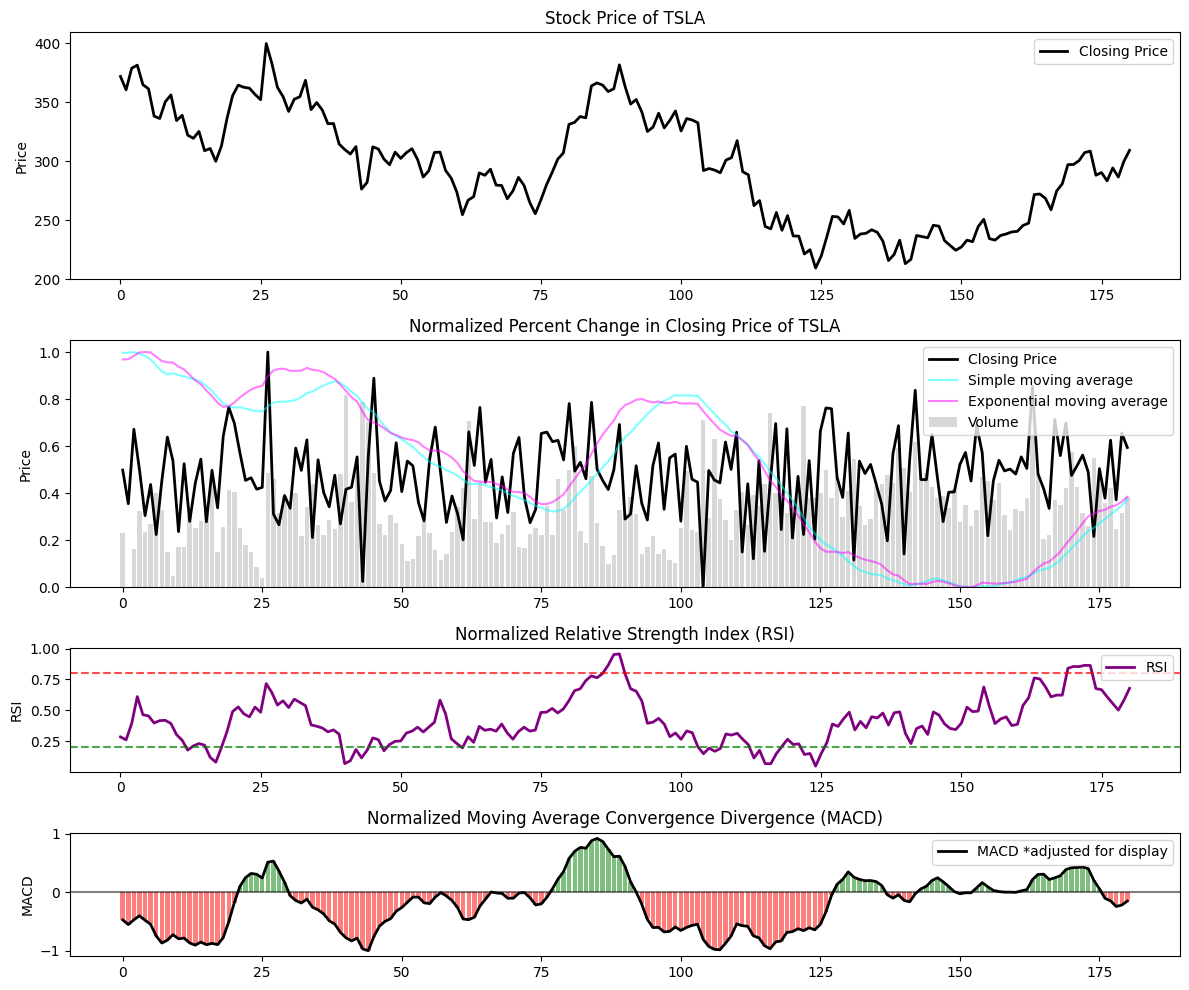

In [ ]:
fig, axs = plt.subplots(4, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 2, 1, 1]})

# Plot stock price
axs[0].plot(plotting_data.index, plotting_data['close'], label="Closing Price", color='black', linewidth=2)
axs[0].set_title(f"Stock Price of {ticker}")
axs[0].set_ylabel("Price")
axs[0].legend(loc="upper right")

# Plot percent change with volume
axs[1].bar(plotting_data.index, plotting_data['volume'], label=f"Volume", color='grey', alpha=0.3)
axs[1].plot(plotting_data.index, plotting_data['percent_close'], label="Closing Price", color='black', linewidth=2)
axs[1].plot(plotting_data.index, plotting_data['sma'], label="Simple moving average", color='cyan', alpha=0.5)
axs[1].plot(plotting_data.index, plotting_data['ema'], label="Exponential moving average", color='magenta', alpha=0.5)
axs[1].set_title(f"Normalized Percent Change in Closing Price of {ticker}")
axs[1].set_ylabel("Percent")
axs[1].legend(loc="upper right")

# Plot RSI
axs[2].plot(plotting_data.index, plotting_data['rsi'], label="RSI", color='purple', linewidth=2)
axs[2].axhline(0.8, linestyle='dashed', color='red', alpha=0.7)
axs[2].axhline(0.2, linestyle='dashed', color='green', alpha=0.7)
axs[2].set_title("Normalized Relative Strength Index (RSI)")
axs[2].set_ylabel("RSI")
axs[2].legend(loc="upper right")

# Plot MACD
axs[3].plot(plotting_data.index, 2*(plotting_data['macd']-0.5), label="MACD *adjusted for display", color='black', linewidth=2)
axs[3].bar(plotting_data.index, 2*(plotting_data['macd']-0.5), 
           color=['green' if v >= 0 else 'red' for v in 2*(plotting_data['macd']-0.5)], 
           alpha=0.5)
axs[3].axhline(0, color='black', alpha=0.5)
axs[3].set_title("Normalized Moving Average Convergence Divergence (MACD)")
axs[3].set_ylabel("MACD")
axs[3].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Define Model

In [46]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, hidden_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, hidden_dim)
        
    def positional_encoding(self, seq_len, d_model):
        position = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        return tf.convert_to_tensor(pe, dtype=tf.float32)
        
    def call(self, x):
        return x + self.pos_encoding[:x.shape[1], :]

class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, sequence_length, hidden_dim, output_size, num_heads=4, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_heads = num_heads
        
        self.positional_encoding_layer = PositionalEncoding(sequence_length, hidden_dim)
        
        self.encoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim // num_heads)
            for _ in range(num_layers)
        ]
        
        self.norm_layers_1 = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6)
            for _ in range(num_layers)
        ]
        
        self.norm_layers_2 = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6)
            for _ in range(num_layers)
        ]
        
        self.dropout_layers = [
            tf.keras.layers.Dropout(dropout_rate)
            for _ in range(num_layers)
        ]
        
        self.ffn_layers = [
            tf.keras.Sequential([
                tf.keras.layers.Dense(hidden_dim * 4, activation="relu"),
                tf.keras.layers.Dense(hidden_dim)
            ])
            for _ in range(num_layers)
        ]
        
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense1 = tf.keras.layers.Dense(hidden_dim // 2, activation="relu")
        self.dense2 = tf.keras.layers.Dense(output_size)
        self.price_change_output = tf.keras.layers.Dense(1, name="price_change_output")
        self.direction_output = tf.keras.layers.Dense(1, activation="sigmoid", name="direction_output")
    
    def call(self, x, training=None):
        # Apply Positional Encoding
        x = self.positional_encoding_layer(x)
        
        # Transformer Encoder Blocks
        for i in range(self.num_layers):
            # First sub-layer: Multi-head attention with residual connection and layer normalization
            attn_output = self.encoder_layers[i](x, x, attention_mask=None, training=training)
            x = self.norm_layers_1[i](x + attn_output)
            x = self.dropout_layers[i](x, training=training)
            
            # Second sub-layer: Feed forward network with residual connection and layer normalization
            ffn_output = self.ffn_layers[i](x)
            x = self.norm_layers_2[i](x + ffn_output)
            x = self.dropout_layers[i](x, training=training)
        
        # Reduce sequence dimension using Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Fully Connected Layers
        x = self.dense1(x)
        
        # Output layers for both price change and direction prediction
        price_change_pred = self.price_change_output(x)
        direction_pred = self.direction_output(x)
        
        return {"price_change_output": price_change_pred, "direction_output": direction_pred}

### Define Loss Function

Implement a custom loss function that combines regression + classification.

- Regression Loss: Mean Squared Error (MSE) for price change prediction

- Classification Loss: Binary Crossentropy for up/down direction prediction

In [47]:
def combined_loss(y_true, y_pred):
    price_change_true, direction_true = y_true[:, 0], y_true[:, 1]
    price_change_pred, direction_pred = y_pred

    # Regression loss (MSE)
    reg_loss = tf.keras.losses.MeanSquaredError()(price_change_true, price_change_pred)

    # Classification loss (Binary Crossentropy)
    class_loss = tf.keras.losses.BinaryCrossentropy()(direction_true, direction_pred)

    # Combine both losses (adjust weight of classification loss)
    return reg_loss + 0.5 * class_loss

### Train Model

In [48]:
num_layers = 2
sequence_length = prev_days
hidden_dim = num_features
output_size = 2
num_heads = 4
dropout_rate = 0.1


# Initialize Transformer model
model = TransformerModel(num_layers, sequence_length, hidden_dim, output_size, num_heads, dropout_rate)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "price_change_output": tf.keras.losses.MeanSquaredError(),
        "direction_output": tf.keras.losses.BinaryCrossentropy()
    },
    loss_weights={
        "price_change_output": 0.3,
        "direction_output": 0.7
    },
    metrics={
        "price_change_output": ["mae"],
        "direction_output": ["accuracy"]
    }
)

# Train the model
history = model.fit(
    x=train_x,
    y={"price_change_output": train_y[:, 0], "direction_output": train_y[:, 1]},  # Separate outputs
    epochs=50,
    batch_size=64,
    validation_data=(test_x, {"price_change_output": test_y[:, 0], "direction_output": test_y[:, 1]})
)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - direction_output_accuracy: 0.4683 - direction_output_loss: 1.1169 - loss: 1.2316 - price_change_output_loss: 0.1147 - price_change_output_mae: 0.2779 - val_direction_output_accuracy: 0.3960 - val_direction_output_loss: 1.3365 - val_loss: 1.3647 - val_price_change_output_loss: 0.0299 - val_price_change_output_mae: 0.1338
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - direction_output_accuracy: 0.4683 - direction_output_loss: 1.0648 - loss: 1.1023 - price_change_output_loss: 0.0375 - price_change_output_mae: 0.1529 - val_direction_output_accuracy: 0.3960 - val_direction_output_loss: 1.0858 - val_loss: 1.1223 - val_price_change_output_loss: 0.0384 - val_price_change_output_mae: 0.1533
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - direction_output_accuracy: 0.4683 - direction_output_loss: 0.8977 - loss: 0.9341 - price_change_output_loss: 0.0364 - price_change_output_mae: 0.1500 - val_direction_output_accuracy: 0.3960 -

### Plot Performance

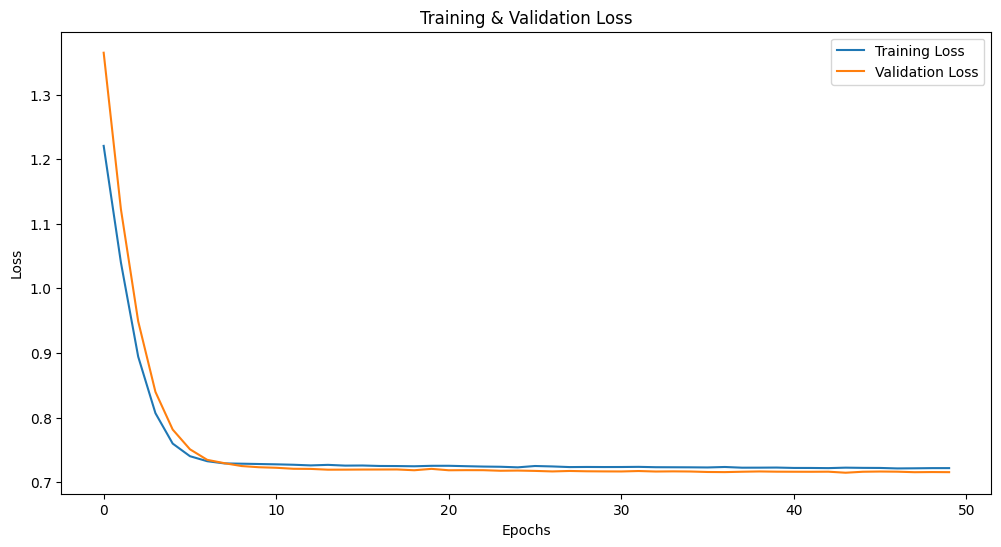

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

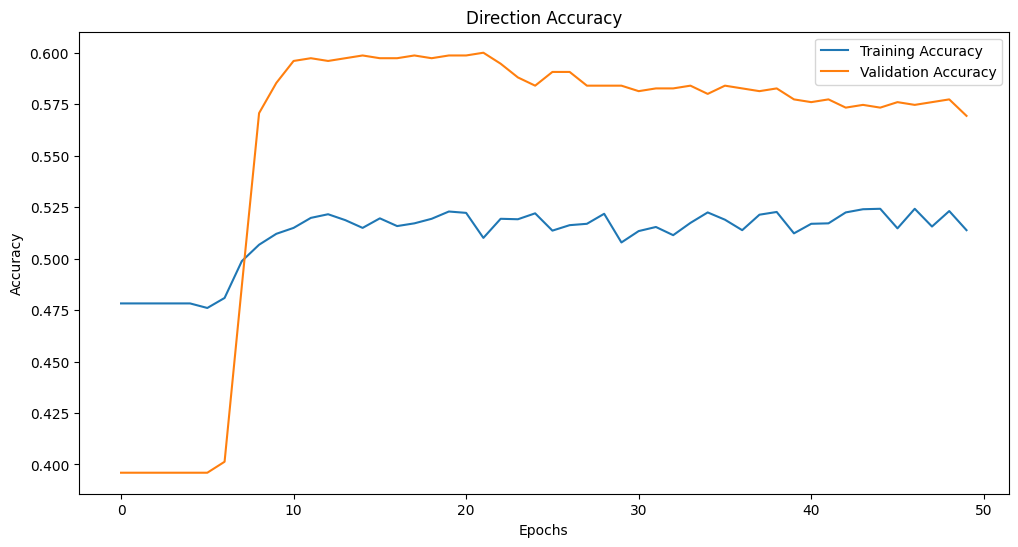

In [50]:
direction_accuracy = history.history['direction_output_accuracy']
val_direction_accuracy = history.history['val_direction_output_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(direction_accuracy, label="Training Accuracy")
plt.plot(val_direction_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Direction Accuracy")
plt.legend()
plt.show()

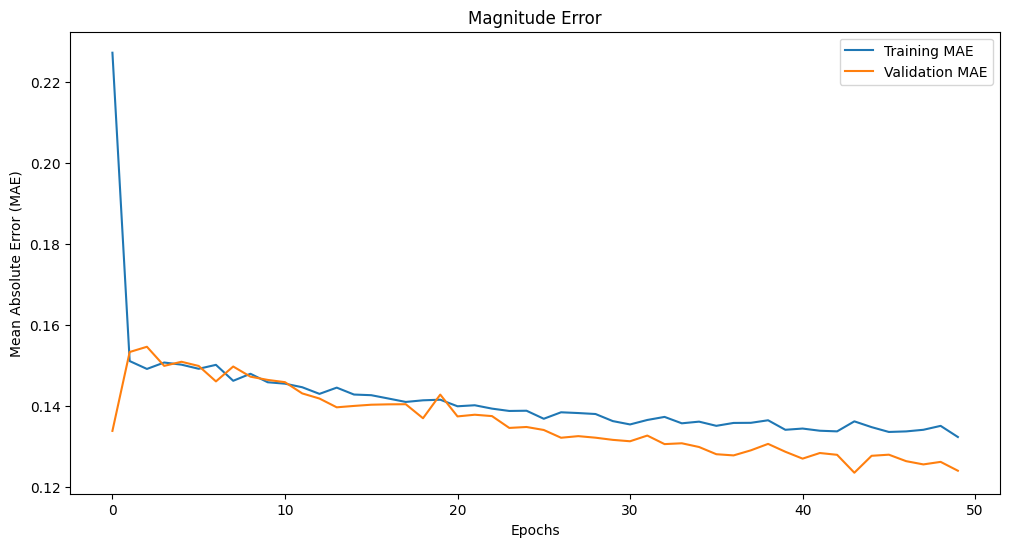

In [54]:
price_change_output_mae = history.history['price_change_output_mae']
val_price_change_output_mae = history.history['val_price_change_output_mae']

plt.figure(figsize=(12, 6))
plt.plot(price_change_output_mae, label="Training MAE")
plt.plot(val_price_change_output_mae, label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Magnitude Error")
plt.legend()
plt.show()

In [ ]:
train_pred = model.predict(train_x)
train_price_change_pred = train_pred['price_change_output']
train_direction_pred = (train_pred['direction_output'] > 0.5).astype(int)

train_actual_price_change = train_y[:, 0]
train_actual_direction = train_y[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(train_actual_price_change, train_price_change_pred, alpha=0.5)
plt.xlabel("Actual Price Change")
plt.ylabel("Predicted Price Change")
plt.title("Predicted vs. Actual Price Change")
plt.axline((0, 0), slope=1, color='red', linestyle='dashed')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [85]:
train_pred = model.predict(train_x)
train_pred_price_change= train_pred['price_change_output']
train_pred_direction = (train_pred['direction_output'] > 0.5).astype(int)
train_actual_price_change = train_y[:, 0]
train_actual_direction = train_y[:, 1]

test_pred = model.predict(test_x)
test_pred_price_change = test_pred['price_change_output']
test_pred_direction = (test_pred['direction_output'] > 0.5).astype(int)
test_actual_price_change = test_y[:, 0]
test_actual_direction = test_y[:, 1]

142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


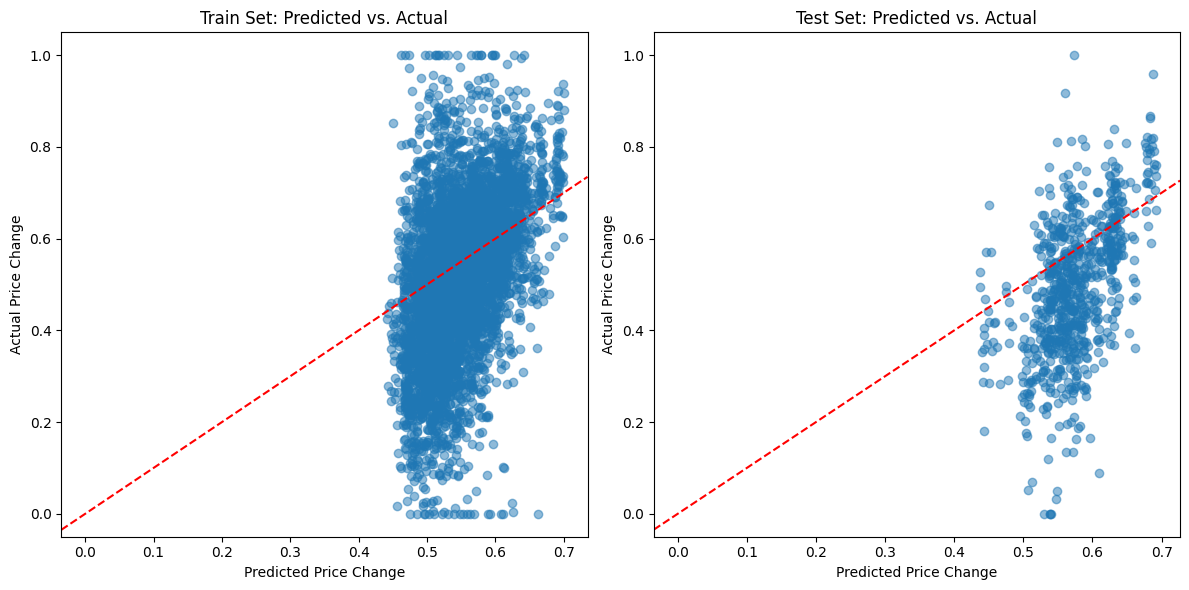

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(train_pred_price_change, train_actual_price_change, alpha=0.5, label="Train Data")
axs[0].set_xlabel("Predicted Price Change")
axs[0].set_ylabel("Actual Price Change")
axs[0].set_title("Train Set: Predicted vs. Actual")
axs[0].axline((0, 0), slope=1, color="red", linestyle="dashed")  # Reference line

axs[1].scatter(test_pred_price_change, test_actual_price_change, alpha=0.5, label="Test Data")
axs[1].set_xlabel("Predicted Price Change")
axs[1].set_ylabel("Actual Price Change")
axs[1].set_title("Test Set: Predicted vs. Actual")
axs[1].axline((0, 0), slope=1, color="red", linestyle="dashed")  # Reference line

plt.tight_layout()
plt.show()

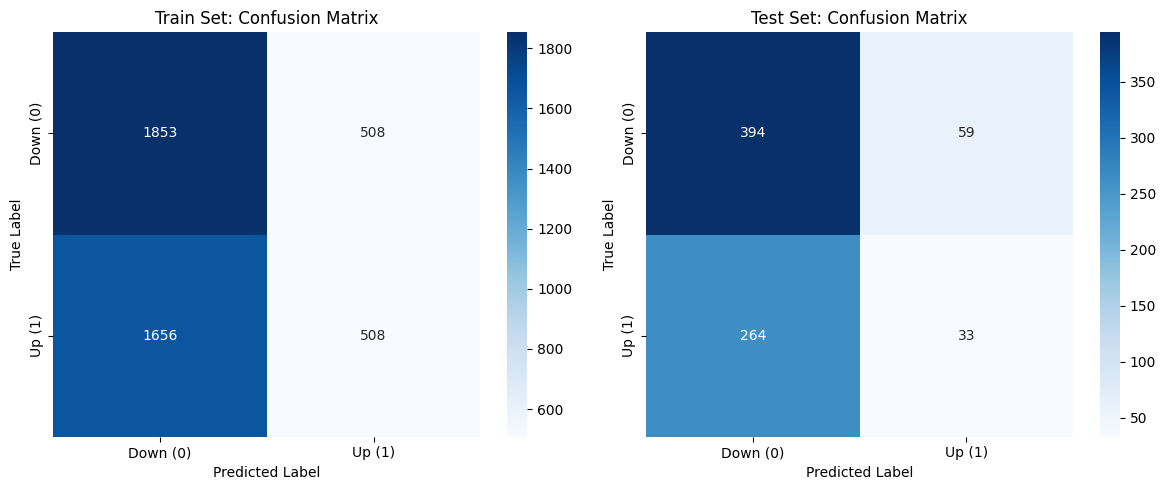

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

train_cm = confusion_matrix(train_actual_direction, train_pred_direction)
test_cm = confusion_matrix(test_actual_direction, test_pred_direction)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"], ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Train Set: Confusion Matrix")

sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"], ax=axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Test Set: Confusion Matrix")

plt.tight_layout()
plt.show()